# Face Slicing
Exploring how mesh faces can be cut along edges and preserve the uv's

## Workflow

1) get the parametric edges on the texture map
2) foreach triangle in the mesh, check if it slices the line
3) find the slice points on the triangle and interpolate all the values
4) make a new mesh with the new faces


### Data Format
All line segments are 2d numpy arrays 
`[[x,y],[x,y]]`

## Import the mesh
finding the slice points of the fave based on its uv coordinates

In [1]:
from context import segmentationtools

# Import the mesh
import open3d as o3d
import segmentationtools as st
import numpy as np
from matplotlib import pyplot as plt

meshPath = "localfiles/triangle.obj"
mesh = o3d.io.read_triangle_mesh(meshPath, True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [18]:
st.show_geometries([mesh])

## Get The Mesh Texture
The image texture of the mesh is stored in the textures of the 3d mesh, currenty only working for meshes with one image texture

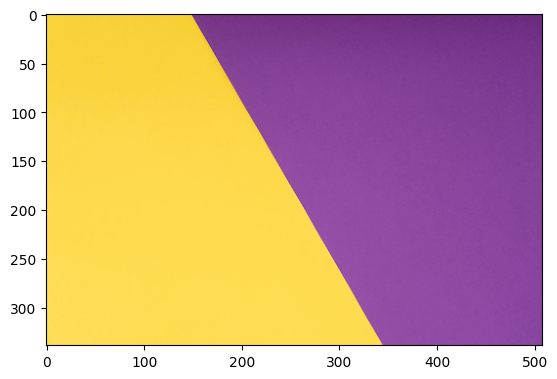

In [19]:
# Get the uv image
img = np.asarray(mesh.textures[0])
st.show_img(img)

## Find the edges in the image
Use opencv to perform an edge detection, then use Houghlines to estimate parametric straight lines
All functions terurn tuples of 2 points to define the line

Edge point values: 
 [[148.95637344   0.        ]
 [344.67813565 339.        ]]


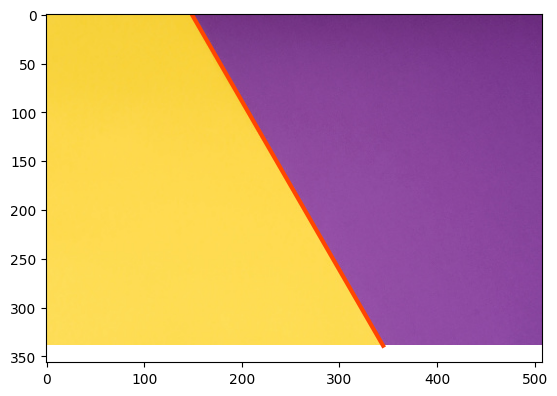

In [20]:
# Detect the edges and points of the intersection
lines = st.detect_edges(img)

plt.imshow(img)
for line in lines:
    points = st.get_edge_points(line, img.shape[1], img.shape[0])
    print("Edge point values: \n",points)
    plt.plot(*zip(*points),color='orangered', linewidth=3)
plt.show()

## Plot the triangle UV's
After we got the points, we need to get the uv coordinates of the triangle face. and map it to the texture.

UV coordinates: 
 [[486.21696067  61.16271722]
 [254.         296.51041192]
 [ 21.78303933  61.16271722]]


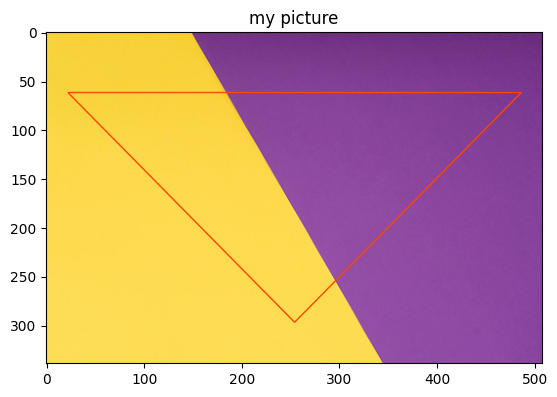

In [21]:
# Scale the uv coordinates with the image dimensions
uvPoints = np.asarray(mesh.triangle_uvs) * np.array([img.shape[1],img.shape[0]])
print("UV coordinates: \n", uvPoints)
plt.imshow(img)
plt.fill(*zip(*uvPoints), facecolor='none', edgecolor='orangered', linewidth=1)
plt.title('my picture')
plt.show()

## Finding the intersections of the triangle and the edge line
We need to check if each edge intersects with the line and if the intersectionpoint is within the bounds of the 2 line segments

The resulting intersection points are: 
 [[295.72943893 254.2183794 ]
 [184.26868847  61.16271722]]


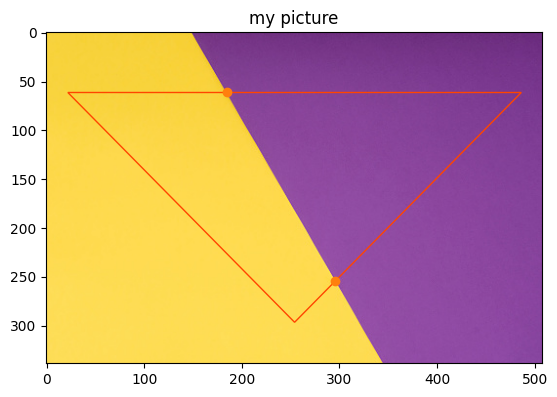

In [22]:
plt.imshow(img)
plt.fill(*zip(*uvPoints), facecolor='none', edgecolor='orangered', linewidth=1)
points = st.find_triangle_intersection(uvPoints, st.get_edge_points(lines[0], img.shape[1], img.shape[0]))
print("The resulting intersection points are: \n", points)
plt.scatter(*zip(*points))
plt.title('my picture')
plt.show()

## Creating new triangles
we need to create new triangles by interpolating the coordinates of the existing triangles
- find the edge that has no cut
- connect the opposite point of the uncut edge and create a new triangle with the 2 new points
- create a second triangle from the uncut edge and a new point linked to the edge point
- create the last triangle from the new cut line and the other existing point

In [23]:
def cut_triangle(edgePoints, line):

    # Define the 3 lines the index corresponds to the oposite point
    tLine0 = ((edgePoints[1][0], edgePoints[1][1]), (edgePoints[2][0], edgePoints[2][1]))
    tLine1 = ((edgePoints[0][0], edgePoints[0][1]), (edgePoints[2][0], edgePoints[2][1]))
    tLine2 = ((edgePoints[0][0], edgePoints[0][1]), (edgePoints[1][0], edgePoints[1][1]))
    tLines = np.array([tLine0, tLine1, tLine2])

    # Loop over the edges and check for intersections
    case = -1
    points = np.array([None,None,None])

    for i in range(3):
        points[i] = st.line_segment_intersection(tLines[i], line)
        if(np.all(points[i]) == None):
            case = i
        
    if(case == -1): 
        return [edgePoints]

    # Generally, if a line intersects a triangle, it always intersects with exacly 2 edges.
    # we can generalize the generation of triangles by looping over the points and starting from the edge that was not cut.
    otherP1 = (case + 1) % 3
    otherP2 = (case + 2) % 3
    newTriangle0 = np.vstack((edgePoints[case], points[otherP2], points[otherP1]))
    newTriangle1 = np.vstack((points[otherP1], points[otherP2],edgePoints[otherP1]))
    newTriangle2 = np.vstack((edgePoints[otherP1], edgePoints[otherP2],points[otherP1]))

    return [newTriangle0, newTriangle1, newTriangle2]

    # There are some edge cases where a line intersects with a points
    # These still have to be adressed

newTriangles = cut_triangle(edgePoints = uvPoints, line = st.get_edge_points(lines[0], img.shape[1], img.shape[0]))

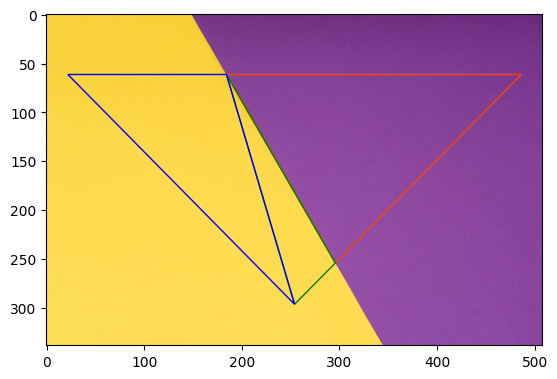

In [24]:
plt.imshow(img)
plt.fill(*zip(*newTriangles[0]), facecolor='none', edgecolor='orangered', linewidth=1)
plt.fill(*zip(*newTriangles[1]), facecolor='none', edgecolor='green', linewidth=1)
plt.fill(*zip(*newTriangles[2]), facecolor='none', edgecolor='blue', linewidth=1)
plt.show()

## Creating 3D Triangles

I have:
- the 3D location of the 3 original points
- the 2D location of the original point
- the 2D location of the new points

I need:
- the 3D location of the new points 

In [25]:
# Find the interpolation value 't' of the 2 new points in relation to the existing points
print("New Triangle UV coordinates: \n", newTriangles[0])
meshPoints3d = np.asarray(mesh.vertices)
print("Original Triangle UV coordinates: \n", uvPoints)
print("Original Triangle 3D position: \n", np.asarray(meshPoints3d))


New Triangle UV coordinates: 
 [[486.21696067  61.16271722]
 [295.72943893 254.2183794 ]
 [184.26868847  61.16271722]]
Original Triangle UV coordinates: 
 [[486.21696067  61.16271722]
 [254.         296.51041192]
 [ 21.78303933  61.16271722]]
Original Triangle 3D position: 
 [[ 1.          0.          0.59346402]
 [ 0.          0.         -0.925264  ]
 [-1.          0.          0.59346402]]


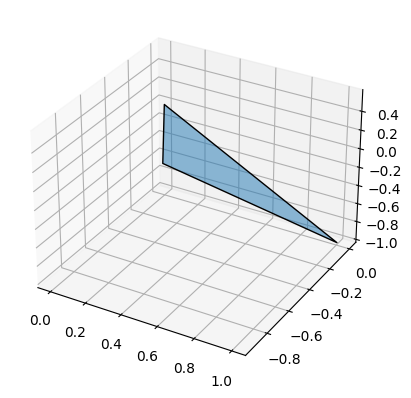

In [26]:
ax = plt.axes(projection='3d')

ax.plot_trisurf(
    *meshPoints3d, 
    edgecolor=[[0,0,0]], 
    linewidth=1.0, 
    alpha=0.5, 
    shade=False)


In [27]:

def interpolate_coordinate(new2dPoint, og2dPoint1, og2dPoint2, og3dPoint1, og3dpoint2):
    val1 = np.interp(new2dPoint[0], [og2dPoint2[0], og2dPoint1[0]], [0,1])#[og3dPoint1[0], og3dpoint2[0]])
    val2 = np.interp(new2dPoint[1], [og2dPoint1[1], og2dPoint2[1]], [0,1])#[og3dPoint1[1], og3dpoint2[1]])
    return val1, val2

def interpolate_coordinate3d(new2dPoint, og2dPoint1, og2dPoint2, og3dPoint1, og3dPoint2):
    val1 = np.interp(new2dPoint[0], [og2dPoint2[0], og2dPoint1[0]], [og3dPoint2[0], og3dPoint1[0]])
    val2 = np.interp(new2dPoint[1], [og2dPoint1[1], og2dPoint2[1]], [og3dPoint1[1], og3dPoint2[1]])
    return val1, val2

print((
    newTriangles[0][2],
    newTriangles[0][0],
    newTriangles[2][1]
    ))

print(interpolate_coordinate(
    newTriangles[0][2],
    newTriangles[0][0],
    newTriangles[2][1],
    meshPoints3d[0],
    meshPoints3d[2]
    ))

new3dPoint = interpolate_coordinate3d(
    newTriangles[0][2],
    newTriangles[0][0],
    newTriangles[2][1],
    meshPoints3d[0],
    meshPoints3d[2]
    )
print(new3dPoint)


(array([184.26868847,  61.16271722]), array([486.21696067,  61.16271722]), array([21.78303933, 61.16271722]))
(0.3498574106559067, 0.0)
(-0.3002851786881866, 0.0)
